## Imports

In [83]:
import pandas as pd
import numpy as np
import datetime, os

import tensorflow as tf

import keras

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from matplotlib import pyplot as plt

from keras import Input
from keras import Model
from keras import layers
from keras import models
from keras import losses
from keras.utils import to_categorical
from keras.preprocessing import timeseries_dataset_from_array

## Test whether Notebook is running on Google Colab

In [84]:
csvPath = ''
if 'google.colab' in str(get_ipython()):
  csvPath = 'https://github.com/DridriLaBastos/Masterials/raw/main/PatientsHTA.zip'
else:
  csvPath = 'PatientsHTA.zip'

In [85]:
dateColumnNames = [
    'contact_date',
    'Glycemie_der_date',
    'HbA1c_der_date',
    'der_date_poids',
    'der_date_taille',
    'first_contact_date'
]

df = pd.read_csv(csvPath,engine='c',parse_dates=dateColumnNames)

# Suppression des lignes trop peu nombreuses

Nous souhaitons faire un apprentissage en utilisant la dimension temporelle comme filtre pour le CNN. Pour ça il faut donc que nous ayons plusieurs entrées. Avant de commencer à traîter les données, nous supprimons toutes les personnes qui n'ont pas rendu visite assez souvent à leur médecin. Ainsi, par le biais de ```person_id```, nous avons choisi arbitrairement que pour être utile à l'apprentissage, il faut au moins 3 visites par patients, soient toutes les lignes dont le ```person_id```est contenu plus de 3 fois dans tout le jeu de données.

In [86]:
VISIT_NUMBER = 4
valueCounts = df.person_id.value_counts()
dfEnought = df[df.person_id.isin(valueCounts[valueCounts.values >= VISIT_NUMBER].index)]

# Suppression des colonnes innutiles

## Suppression de la colonne ```age_now```

Nous pouvons supprimer la colonne ```age_now``` car les données qu'elle contient sont identiques à celles de la colonne ```year_of_birth```.

In [87]:
dfWithoutAgeNow = dfEnought.drop('Age_now', axis='columns')

## Suppression de la colonne ```contact_id```

En effet, la colonne ```contact_id``` ne représente aucun intérêt pour l'apprentissage car elle ne contient aucun information à même d'influer sur la prédiction.

In [88]:
dfWithoutContactID = dfWithoutAgeNow.drop('contact_id',axis='columns')

## Suppression des noms de médicaments

In [89]:
dfGroupedByMoleculeLabel = dfWithoutContactID.groupby('product_atc_code')[['molecule_label','short_name','long_name','Classe','product_atc']].count()
dfGroupedByMoleculeLabel

,molecule_label,short_name,long_name,Classe,product_atc
product_atc_code,,,,,
C02AC06,4288,4288,4288,4288,4288
C03BX03,932,932,932,932,932
C03CA01,877,877,877,877,877
C03DA01,187,187,187,187,187
C03DA04,27,27,27,27,27
C03EA04,75,75,75,75,75
C03EB01,14,14,14,14,14
C07AA05,2,2,2,2,2
C07AB03,6466,6466,6466,6466,6466


Nous voyons qu'il existe différentes colonnes dont le but est de désigner le médicament prescrit lors de la visite, or nous n'avons besoin que d'une seule colonne garder cette information. De ce fait, nous avons choisi de garder ```product_atc_code```.

In [90]:
dropColumnNames = dfGroupedByMoleculeLabel.columns.to_list()
dfWithATCCode = dfWithoutContactID.drop(dropColumnNames, axis='columns')
dfWithATCCode

,person_id,specialty_label,contact_date,cip,dosage_1,dose_1,dose_2,product_atc_code,box,quantity,frequency_label,duration,Traitement_Autres_A10_dep_201701,Traitement_Insulines_dep_201701,Pulse,Tension Diastolique,Tension Systolique,Glycemie_prescription,Glycemie_der_date,Glycemie_der_mesure,HbA1c_prescription,HbA1c_der_date,HbA1c_der_mesure,gender_code,Age_presc,year_of_birth,Poids,der_date_poids,Taille,der_date_taille,first_contact_date
1,263659.0,Médecin généraliste,2014-09-24,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,70.0,110.0,60.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,96.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
2,263659.0,Médecin généraliste,2014-09-12,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,70.0,118.0,70.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,96.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
3,263659.0,Médecin généraliste,2015-03-26,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,60.0,120.0,70.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,97.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
4,263659.0,Médecin généraliste,2015-06-05,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,Jour,NaN,NaN,NaN,60.0,120.0,70.0,NaN,2008-02-08,1.01,NaN,NaT,NaN,M,97.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
6,25182917.0,Médecin généraliste,2013-03-27,3.400960e+12,300.0,16800.0,56.0,C09XA02,2.0,1.00,Jour,84.0,NaN,NaN,64.0,145.0,85.0,NaN,NaT,NaN,NaN,NaT,NaN,M,63.0,1950.0,NaN,NaT,NaN,NaT,2011-04-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50625,26636453.0,Médecin généraliste,2016-11-16,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.75,Jour,28.0,OUI,NaN,60.0,120.0,60.0,NaN,2017-10-03,3.39,NaN,2017-10-03,5.60,M,79.0,1937.0,83.9,2018-02-21,NaN,NaT,2012-02-14
50627,18889430.0,Médecin généraliste,2013-02-01,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.50,Jour,28.0,NaN,NaN,60.0,120.0,70.0,NaN,2016-02-03,6.27,NaN,2017-05-15,8.01,M,85.0,1928.0,NaN,NaT,NaN,NaT,2007-12-02
50629,2222336.0,Médecin généraliste,2013-07-01,3.400940e+12,500.0,15000.0,30.0,C03CA01,2.0,0.25,Jour,240.0,NaN,NaN,72.0,130.0,70.0,NaN,NaT,NaN,NaN,NaT,NaN,F,78.0,1935.0,NaN,NaT,NaN,NaT,2006-02-23
50631,11363518.0,Médecin généraliste,2013-01-24,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.25,Jour,120.0,NaN,NaN,72.0,139.0,70.0,NaN,NaT,NaN,NaN,NaT,NaN,M,80.0,1933.0,NaN,NaT,NaN,NaT,1998-01-27


## Suppression des colonnes ```'*der*'```

Les colonnes ```'*der*'``` contiennent la dernière donnée. Cette donnée peut être récupérée grâce à la date de la visite et aux valeurs mesurées. Par exemple, il n'est pas nécessaire d'avoir une colonne ```der_date``` ou ```der_mesure```. Les données de ces deux types de colonnes peuvent être récupérées grâce à la ligne qui correspond à la dernière date de la mesure, que nous pouvons trouver grâce à la colonne ```contact_date```.

In [91]:
derColumnNames = []

for c in dfWithATCCode.columns:
    if ('der_date' in c) or ('der_mesure' in c):
        derColumnNames.append(c)

dfWithoutDer = dfWithATCCode.drop(derColumnNames,axis='columns')

## Suppression des colonnes ```Taille``` et ```Poids```

In [92]:
print(f"Taille: {dfWithoutDer.Taille.isnull().sum()}/{len(dfWithoutDer.Taille)} valeurs nulles (={dfWithoutDer.Taille.isnull().sum()/len(dfWithoutDer.Taille)*100:.2f}%)")

print(f"Poids: {dfWithoutDer.Poids.isnull().sum()}/{len(dfWithoutDer.Poids)} valeurs nulles (={dfWithoutDer.Poids.isnull().sum()/len(dfWithoutDer.Poids)*100:.2f}%)".format())

Taille: 18150/36876 valeurs nulles (=49.22%)
Poids: 11389/36876 valeurs nulles (=30.88%)


Nous voyons qu'il y a beaucoup trop de valeur nulles. Ces deux colonnes semblent donc difficilement exploitable. Nous pouvons cependant vérifier si pour les patients toutes les valeurs sont à nulles ou s'il n'existe que quelques entrées à nulle par patient mais qu'il y en a beaucoup. Dans ce cas nous pourrions enlever les lignes contenant des valeurs nulles, ou trouver un moyen d'attribuer une valeur à la place de Nan

In [93]:
dfPersonIdIndex = dfWithoutDer.set_index('person_id',drop=True).sort_index()
dfTPGroupBy = dfPersonIdIndex.groupby('person_id')

In [94]:
maybeUseful = 0
valeurNulle = 0
for i,_ in dfTPGroupBy:
    if dfPersonIdIndex.loc[i].Taille.isnull().sum() > 0:
        valeurNulle += 1
        if dfPersonIdIndex.loc[i].Taille.isnull().sum() < len(dfPersonIdIndex.loc[i].Taille):
            maybeUseful += 1

print(f"Taille: {maybeUseful} / {valeurNulle} utilisables")

maybeUseful = 0
valeurNulle = 0
c = 0
for i,_ in dfTPGroupBy:
    if dfPersonIdIndex.loc[i].Poids.isnull().sum() > 0:
        valeurNulle += 1
        if dfPersonIdIndex.loc[i].Poids.isnull().sum() < len(dfPersonIdIndex.loc[i].Poids):
            maybeUseful += 1

print(f"Poids: {maybeUseful} / {valeurNulle} utilisables")

Taille: 0 / 2219 utilisables
Poids: 0 / 1498 utilisables


In [95]:
tailleNan = 0
poidsNan = 0
oneOfBoth = 0
bothNan = 0
totalEntries = 0
for i,_ in dfTPGroupBy:
    totalEntries += 1
    hasTailleNan = False
    hasPoidsNan = False
    if dfPersonIdIndex.loc[i].Taille.isnull().sum() != 0:
        tailleNan += 1
        hasTailleNan = True
    if dfPersonIdIndex.loc[i].Poids.isnull().sum() != 0:
        poidsNan += 1
        hasPoidsNan = True
    if hasTailleNan or hasPoidsNan:
        oneOfBoth += 1
    if hasTailleNan and hasPoidsNan:
        bothNan += 1
print(" --- Statistique par Utilisateur --- ")
print(f"{tailleNan} / {totalEntries} ({tailleNan/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour la taille")
print(f"{poidsNan} / {totalEntries} ({poidsNan/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour le poids")
print(f"{oneOfBoth} / {totalEntries} ({oneOfBoth/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour la taille ou le poids")
print(f"{bothNan} / {totalEntries} ({bothNan/totalEntries*100:.2f}%) des utilisateurs ont les deux valeurs nulle pour la taille ou le poids")



 --- Statistique par Utilisateur --- 
2219 / 4227 (52.50%) des utilisateurs ont une valeur nulle pour la taille
1498 / 4227 (35.44%) des utilisateurs ont une valeur nulle pour le poids
2220 / 4227 (52.52%) des utilisateurs ont une valeur nulle pour la taille ou le poids
1497 / 4227 (35.42%) des utilisateurs ont les deux valeurs nulle pour la taille ou le poids


Nous concluons de l'analyse de ces données que soit toutes les valeurs de poids et de tailles sont entrées, soit aucunes. Cela rend ces informations innexploitables et nous supprimons donc les colonnes

In [96]:
dfWithoutPT = dfWithoutDer.drop(['Taille', 'Poids'],axis='columns')

## Suppressions diverses

Enfin, certaines colonnes n'apportent pas d'informations nécessaires pour la prédiction, nous choisissons de toutes les supprimer ici

In [97]:
dfWithoutPT.isnull().sum()

person_id                               0
specialty_label                         0
contact_date                            0
cip                                     0
dosage_1                                0
dose_1                                  0
dose_2                                  0
product_atc_code                        0
box                                   253
quantity                              153
frequency_label                       147
duration                             5100
Traitement_Autres_A10_dep_201701    29649
Traitement_Insulines_dep_201701     34850
Pulse                                   0
Tension Diastolique                     0
Tension Systolique                      0
Glycemie_prescription               35937
HbA1c_prescription                  35766
gender_code                             0
Age_presc                               0
year_of_birth                           0
first_contact_date                      0
dtype: int64

Les colonnes restantes avec des valeurs ```Nan``` ne nous intéresse pas, nous pouvons les supprimer

In [98]:
nullAmount = dfWithoutPT.isnull().sum()

columnNameToDrop = nullAmount[nullAmount.values > 0].index
dfFinal = dfWithoutPT.drop(columnNameToDrop,axis='columns').drop(['cip','dosage_1','dose_1','dose_2','specialty_label','gender_code'],axis='columns')

# Traîtement des données

## Conversion des données

### Ajout du temps entre chaque visite (ce que l'on veut prédire)

Nous créons d'abord la colonne ```wait_time``` pour qu'elle ait le type de donnée ```deltatime```. nous itèrerons plus tard sur chaque valeur de cette colonne pour lui enlever la valeur précédante pour chaque utilisateur, et ainsi avoir l'intervalle de temps entre chaque visite

In [99]:
wait_time = dfFinal.contact_date - dfFinal.first_contact_date
dfWithTime = dfFinal.drop('first_contact_date',axis='columns')
dfWithTime['wait_time'] = wait_time
dfWithTime['contactDateYear'] = dfWithTime.contact_date.dt.year
dfWithTime['contactDateMonth'] = dfWithTime.contact_date.dt.month
dfWithTime['contactDateDayOfYear'] = dfWithTime.contact_date.dt.dayofyear

In [100]:
dfWithTime

,person_id,contact_date,product_atc_code,Pulse,Tension Diastolique,Tension Systolique,Age_presc,year_of_birth,wait_time,contactDateYear,contactDateMonth,contactDateDayOfYear
1,263659.0,2014-09-24,C03CA01,70.0,110.0,60.0,96.0,1918.0,6019 days,2014,9,267
2,263659.0,2014-09-12,C03CA01,70.0,118.0,70.0,96.0,1918.0,6007 days,2014,9,255
3,263659.0,2015-03-26,C03CA01,60.0,120.0,70.0,97.0,1918.0,6202 days,2015,3,85
4,263659.0,2015-06-05,C03CA01,60.0,120.0,70.0,97.0,1918.0,6273 days,2015,6,156
6,25182917.0,2013-03-27,C09XA02,64.0,145.0,85.0,63.0,1950.0,723 days,2013,3,86
...,...,...,...,...,...,...,...,...,...,...,...,...
50625,26636453.0,2016-11-16,C03CA01,60.0,120.0,60.0,79.0,1937.0,1737 days,2016,11,321
50627,18889430.0,2013-02-01,C03CA01,60.0,120.0,70.0,85.0,1928.0,1888 days,2013,2,32
50629,2222336.0,2013-07-01,C03CA01,72.0,130.0,70.0,78.0,1935.0,2685 days,2013,7,182
50631,11363518.0,2013-01-24,C03CA01,72.0,139.0,70.0,80.0,1933.0,5476 days,2013,1,24


### Encodage des valeurs non numériques

In [101]:
#specialtyEncoder = LabelEncoder()
ATCEncoder = LabelEncoder()
#genderEncoder = LabelEncoder()
#dfWithTime.specialty_label = specialtyEncoder.fit_transform(dfWithTime.specialty_label)
dfWithTime.product_atc_code = ATCEncoder.fit_transform(dfWithTime.product_atc_code)
#dfWithTime.gender_code = genderEncoder.fit_transform(dfWithTime.gender_code)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd200b44a8>,
      dtype=object)

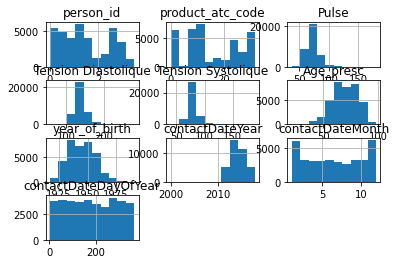

In [102]:
dfWithTime.hist()

### Conversion en ```TimeSeries```

Nous définissons simplement le nouvel index comme la colonne donnant l'intervalle de temps entre chaque visite.

In [103]:
ts = dfWithTime.set_index(['person_id','contact_date']).sort_index()
ts

product_atc_code  ...  contactDateDayOfYear
person_id  contact_date                    ...                      
291.0      2016-10-28                  10  ...                   302
           2016-11-04                  10  ...                   309
           2016-11-21                  10  ...                   326
           2017-01-16                  10  ...                    16
           2017-11-20                  10  ...                   324
...                                   ...  ...                   ...
34823672.0 2017-04-15                   8  ...                   105
           2017-06-26                   8  ...                   177
           2017-08-30                   8  ...                   242
           2017-09-11                   8  ...                   254
           2018-08-02                   8  ...                   214

[36876 rows x 10 columns]

### Attribution des bonnes valeurs de ```time_wait```

In [137]:
#Cellule d'exemples
l = np.array([1,2,4,8,10])
print(f"slice [:-1]: {l[:-1]} --- slice [1:] {l[1:]}")
print(f"{l[1:]} - {l[:-1]} = {l[1:] - l[:-1]}")

slice [:-1]: [1 2 4 8] --- slice [1:] [ 2  4  8 10]
[ 2  4  8 10] - [1 2 4 8] = [1 2 4 2]


In [106]:
tsWithTimeBad = ts.copy()

for i,_ in ts.groupby('person_id'):
    tsWithTimeBad.loc[i].wait_time[:-1] = pd.Series(ts.loc[i].wait_time.to_numpy()[1:] - ts.loc[i].wait_time.to_numpy()[:-1])
    tsWithTimeBad.loc[i].wait_time[-1] = pd.Timedelta(0)
tsWithTime = tsWithTimeBad[tsWithTimeBad.wait_time != pd.Timedelta(0)]
print(f"{len(tsWithTimeBad)} --- {len(tsWithTime)}")

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


36876 --- 31932


In [107]:
tsWithTimeNumber = tsWithTime.copy()
tsWithTimeNumber.wait_time = tsWithTime.wait_time.dt.days
tsWithTimeNumber['wait_time_days'] = tsWithTime.wait_time.dt.days
tsWithTimeNumber['wait_time_weeks'] = (tsWithTime.wait_time.dt.days / 7).astype(int)
tsWithTimeNumber.wait_time.describe()

count    31932.000000
mean       120.784166
std        124.530985
min          1.000000
25%         42.000000
50%         89.000000
75%        158.000000
max       2825.000000
Name: wait_time, dtype: float64

In [108]:
tsWithGoodTime = tsWithTimeNumber[tsWithTimeNumber.wait_time.values <= 300]
tsWithGoodTime.wait_time.describe()

count    29602.000000
mean        94.994696
std         70.240169
min          1.000000
25%         37.000000
50%         84.000000
75%        131.000000
max        300.000000
Name: wait_time, dtype: float64

### Transformation de ```wait_time``` en valeur numérique

In [109]:
tsWithTimeMonth = tsWithGoodTime.copy()
tsWithTimeMonth.wait_time = (tsWithGoodTime.wait_time / 30).astype(int)
tsWithTimeMonth.wait_time[tsWithTimeMonth.wait_time >= 4] = 4
tsWithTimeMonth

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


product_atc_code  ...  wait_time_weeks
person_id  contact_date                    ...                 
291.0      2016-10-28                  10  ...                1
           2016-11-04                  10  ...                2
           2016-11-21                  10  ...                8
           2017-11-20                  10  ...                8
1542.0     2012-05-23                  29  ...                5
...                                   ...  ...              ...
34782602.0 2017-08-30                   8  ...               13
           2017-11-30                   8  ...               10
34823672.0 2017-04-15                   8  ...               10
           2017-06-26                   8  ...                9
           2017-08-30                   8  ...                1

[29602 rows x 12 columns]

In [110]:
tsResetIndex = tsWithTimeMonth.copy()
tsResetIndex = tsResetIndex.reset_index()
print( tsResetIndex )
tsValueCounts = tsResetIndex.person_id.value_counts()
tsIndexed = tsResetIndex[tsResetIndex.person_id.isin(tsValueCounts[tsValueCounts.values >= VISIT_NUMBER].index)]

        person_id contact_date  ...  wait_time_days  wait_time_weeks
0           291.0   2016-10-28  ...               7                1
1           291.0   2016-11-04  ...              17                2
2           291.0   2016-11-21  ...              56                8
3           291.0   2017-11-20  ...              60                8
4          1542.0   2012-05-23  ...              36                5
...           ...          ...  ...             ...              ...
29597  34782602.0   2017-08-30  ...              92               13
29598  34782602.0   2017-11-30  ...              76               10
29599  34823672.0   2017-04-15  ...              72               10
29600  34823672.0   2017-06-26  ...              65                9
29601  34823672.0   2017-08-30  ...              12                1

[29602 rows x 14 columns]


In [111]:
atcCodeValues = tsWithTimeMonth.product_atc_code
waitTimeValues = tsWithTimeMonth.wait_time

tsFinal = pd.concat([tsWithTimeMonth,pd.get_dummies(atcCodeValues),pd.get_dummies(waitTimeValues)],axis='columns').drop(['product_atc_code','wait_time'],axis='columns')

# Prediction

## Creating train/test dataset

In [112]:
VISIT_THRESHOLD = 6
yColumnNames = ['product_atc_code', 'wait_time']

In [113]:
xTrainData, yTrainData,xTestData, yTestData = [],[],[],[]

for i,_ in tsWithTimeMonth.groupby('person_id'):
    currentSeriesX = tsFinal.loc[i].to_numpy().astype('float32')
    currentSeriesY = tsWithTimeMonth.loc[i][yColumnNames].to_numpy().astype('float32')
    for j in range(0,len(currentSeriesX)-VISIT_THRESHOLD+1):
        xData = currentSeriesX[j:j+VISIT_THRESHOLD][:-1]
        yData = currentSeriesY[j:j+VISIT_THRESHOLD][-1:]
        if len(currentSeriesX) <=  VISIT_THRESHOLD+2:
            xTestData.append(xData)
            yTestData.append(yData)
        else:
            xTrainData.append(xData)
            yTrainData.append(yData)

In [114]:
xTrain = np.array(xTrainData).reshape(len(xTrainData),1,xTrainData[0].shape[0],xTrainData[0].shape[1])
yTrain = np.array(yTrainData).reshape(len(yTrainData),yTrainData[0].shape[0],yTrainData[0].shape[1])

xTest = np.array(xTestData).reshape(len(xTestData),1,xTestData[0].shape[0],xTestData[0].shape[1])
yTest = np.array(yTestData).reshape(len(yTestData),yTestData[0].shape[0],yTestData[0].shape[1])

In [115]:
print(f"Data for training: {xTrain.shape[0]}")
print(f"Data for validation and test: {xTest.shape[0]}")

Data for training: 10501
Data for validation and test: 1690


## Model creation

In [116]:
ATC_CODE = 0
WAIT_TIME = 1

In [117]:
YTrain = {
    'outputATC' : yTrain[:,:,ATC_CODE],
    'outputWaitTime' : yTrain[:,:,WAIT_TIME]
}

valNum = int(xTest.shape[0] * 0.8)

XVal = xTest[:valNum]
YVal = {
    'outputATC' : yTest[:valNum,:,ATC_CODE],
    'outputWaitTime' : yTest[:valNum,:,WAIT_TIME]   
}

XTest = xTest[valNum:]
YTest = {
    'outputATC' : yTest[valNum:,:,ATC_CODE],
    'outputWaitTime' : yTest[valNum:,:,WAIT_TIME]
}

In [118]:
print(f"Train. . . . X: {xTrain.shape} --- Y: {yTrain.shape}")
print(f"Validation . X: {XVal.shape} --- Y: {YVal['outputATC'].shape}")
print(f"Test . . . . X: {XTest.shape} --- Y: {YTest['outputATC'].shape}")

Train. . . . X: (10501, 1, 5, 48) --- Y: (10501, 1, 2)
Validation . X: (1352, 1, 5, 48) --- Y: (1352, 1)
Test . . . . X: (338, 1, 5, 48) --- Y: (338, 1)


In [125]:
inputs = Input(shape=xTrain.shape[-3:])
x = layers.Conv1D(filters=64,kernel_size=3)(inputs)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(filters=64,kernel_size=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)

atcDense = layers.Dense(64)(x)
atcDense = layers.LeakyReLU()(atcDense)
atcOutputs = layers.Dense(units=len(ATCEncoder.classes_),activation='softmax',name='outputATC')(atcDense)

wtDense = layers.Dense(64)(x)
wtDense = layers.LeakyReLU()(wtDense)
waitTimeOutputs = layers.Dense(units=tsWithTimeMonth.wait_time.max()+1,activation='softmax',name='outputWaitTime')(wtDense)

model = Model(inputs=inputs,outputs=[atcOutputs,waitTimeOutputs],name="NiceCNN")

In [126]:
model.summary()

Model: "NiceCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 5, 48)]   0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1, 3, 64)     9280        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 1, 3, 64)     0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1, 2, 64)     8256        leaky_re_lu_11[0][0]             
____________________________________________________________________________________________

In [127]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [128]:
#history = model.fit(xTrain,YTrain,epochs=300,validation_data=(XVal,YVal))

## Custom learning loop

In [129]:
loss = keras.losses.SparseCategoricalCrossentropy()

In [131]:
EPOCHS = 5000
BI = False

losses = { 'atc': [], 'wt': [] }
trainAccuracy = { 'atc': [], 'wt': [] }
validationAccuracy = { 'atc': [], 'wt': [] }

for epoch in range(EPOCHS):
    #Computing accuracies
    trainPredictions = model(xTrain, training=False)
    trainPredictionsATC = np.argmax(trainPredictions[ATC_CODE],axis=1).reshape(yTrain[:,:,0].shape)     
    trainPredictionsWT  = np.argmax(trainPredictions[WAIT_TIME],axis=1).reshape(yTrain[:,:,1].shape)    

    trainAccuracy['atc'].append((trainPredictionsATC == yTrain[:,:,0]).sum()/len(yTrain[:,:,0]))        
    trainAccuracy['wt'].append((trainPredictionsWT == yTrain[:,:,1]).sum()/len(yTrain[:,:,1]))          

    validationPredictions = model(XVal, training=False)
    validationPredictionsATC = np.argmax(validationPredictions[ATC_CODE],axis=1).reshape(YVal['outputATC'].shape)     
    validationPredictionsWT  = np.argmax(validationPredictions[WAIT_TIME],axis=1).reshape(YVal['outputWaitTime'].shape)

    validationAccuracy['atc'].append((validationPredictionsATC == YVal['outputATC']).sum()/len(YVal['outputATC']))
    validationAccuracy['wt'].append((validationPredictionsWT == YVal['outputATC']).sum()/len(YVal['outputATC']))

    with tf.GradientTape() as ATCTape, tf.GradientTape() as WTTape, tf.GradientTape() as tape:
        predictions = model(xTrain,training=False)
        ATCLoss = loss(yTrain[:,:,0],predictions[ATC_CODE])     
        WTLoss  = loss(yTrain[:,:,1],predictions[WAIT_TIME])     
        #lossValue = ATCLoss + WTLoss                            

    #Getting the gradients
    ATCGrads = ATCTape.gradient(ATCLoss, model.trainable_variables)     
    WTGrads  = WTTape.gradient(WTLoss,model.trainable_variables)        
    #grads = tape.gradient(lossValue,model.trainable_variables)         

    #Making all elements of the list returned by tf with the same shape
    #by adding 0 where there is no values
    for i in range(len(WTGrads)):
        ATCGradsValue = ATCGrads[i]
        WTGradsValue = WTGrads[i]

        if ATCGradsValue is None:
            ATCGrads[i] = tf.constant(np.zeros(WTGradsValue.shape,dtype='float32'))
        
        if WTGradsValue is None:
            WTGrads[i] = tf.constant(np.zeros(ATCGradsValue.shape,dtype='float32'))

    #putting the gradients in the form of a 1D vector
    gs = np.concatenate([g.numpy().reshape(np.prod(g.shape),) for g in ATCGrads])
    gl = np.concatenate([g.numpy().reshape(np.prod(g.shape),) for g in WTGrads])
    
    if BI:
        if np.linalg.norm(gs) > np.linalg.norm(gl):
            tmp = gs
            gl = gs
            gs = tmp
        
        d = -gs / np.linalg.norm(gs)

        if np.transpose(gs) @ (gs - gl) <= 0:
            D = -gs * (np.linalg.norm(gl) ** 2 - np.transpose(gs) @ gl) / (np.linalg.norm(gs) ** 2 - np.transpose(gs) @ gl) - gl
            d = D / np.linalg.norm(D)
    else:
        d = gs + gl
    
    finalGrads = []

    begin = 0
    for g in ATCGrads:
        shape = g.shape
        length = np.prod(shape)
        finalGrads.append((-1 if BI else 1) * tf.constant(d[begin:begin+length].reshape(shape)))
        begin += length

    model.optimizer.apply_gradients(zip(finalGrads, model.trainable_variables))

    losses['atc'].append(ATCLoss)
    losses['wt'].append(WTLoss)
    lossValue = ATCLoss + WTLoss

    e = epoch + 1
    if (e % 100 == 0) or (epoch == 0):
        print(f"epochs {e:03d} --- loss {lossValue:.3f} (atc: {ATCLoss:.3f}  wait_time: {WTLoss:.3f})")

epochs 001 --- loss 429.399 (atc: 263.489  wait_time: 165.910)
epochs 100 --- loss 6.187 (atc: 3.985  wait_time: 2.202)
epochs 200 --- loss 7.667 (atc: 4.061  wait_time: 3.606)
epochs 300 --- loss 3.979 (atc: 2.381  wait_time: 1.599)
epochs 400 --- loss 3.708 (atc: 2.135  wait_time: 1.574)
epochs 500 --- loss 3.492 (atc: 1.926  wait_time: 1.566)
epochs 600 --- loss 3.899 (atc: 2.198  wait_time: 1.702)
epochs 700 --- loss 3.130 (atc: 1.548  wait_time: 1.582)
epochs 800 --- loss 5.034 (atc: 3.156  wait_time: 1.877)
epochs 900 --- loss 2.539 (atc: 0.980  wait_time: 1.559)
epochs 1000 --- loss 8.171 (atc: 4.954  wait_time: 3.216)
epochs 1100 --- loss 2.321 (atc: 0.759  wait_time: 1.561)
epochs 1200 --- loss 2.028 (atc: 0.471  wait_time: 1.557)
epochs 1300 --- loss 1.859 (atc: 0.308  wait_time: 1.551)
epochs 1400 --- loss 1.759 (atc: 0.217  wait_time: 1.542)
epochs 1500 --- loss 1.703 (atc: 0.166  wait_time: 1.536)
epochs 1600 --- loss 1.663 (atc: 0.132  wait_time: 1.532)
epochs 1700 --- lo

KeyboardInterrupt: ignored

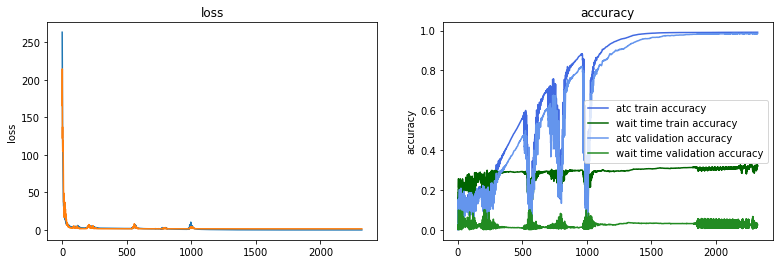

In [132]:
fig, (l,a) = plt.subplots(1,2,sharex=True,figsize=(13,4))
l.title.set_text('loss')
l.set_ylabel('loss')

a.title.set_text('accuracy')
a.set_ylabel('accuracy')

l.plot(losses['atc'],label='atc loss')
l.plot(losses['wt'],label='wait time loss')

a.plot(trainAccuracy['atc'],label='atc train accuracy',c='royalblue')
a.plot(trainAccuracy['wt'],label='wait time train accuracy',c='darkgreen')

a.plot(validationAccuracy['atc'],label='atc validation accuracy',c='cornflowerblue')
a.plot(validationAccuracy['wt'],label='wait time validation accuracy',c='forestgreen')

plt.legend(loc='center right')
plt.show()

In [133]:
predictions = model.predict(XTest)
predictionsATC = np.argmax(predictions[ATC_CODE],axis=1).reshape(YTest['outputATC'].shape)
predictionsWT  = np.argmax(predictions[WAIT_TIME],axis=1).reshape(YTest['outputWaitTime'].shape)

print(f"Précision 'ATC_CODE': {(predictionsATC == YTest['outputATC']).sum()/len(YTest['outputATC'])*100:.2f}%")
print(f"Précision 'WAIT_TIME': {(predictionsWT == YTest['outputWaitTime']).sum()/len(YTest['outputWaitTime'])*100:.2f}%")

Précision 'ATC_CODE': 99.11%
Précision 'WAIT_TIME': 30.47%


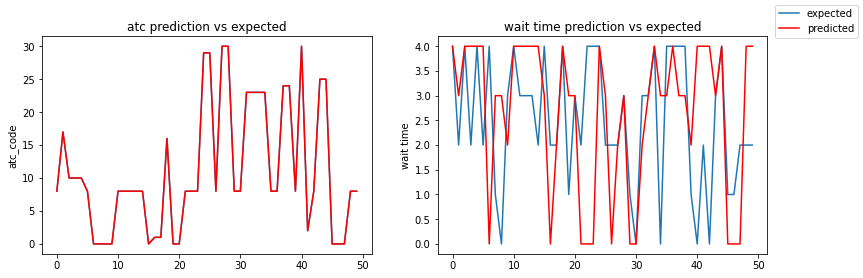

In [135]:
SLICE_START = 200
SLICE_SIZE = 50
SLICE_END = SLICE_START + SLICE_SIZE

fig, (atc,wt) = plt.subplots(1,2,sharex=True,figsize=(13,4))

atc.title.set_text('atc prediction vs expected')
atc.set_ylabel('atc_code')

wt.title.set_text('wait time prediction vs expected')
wt.set_ylabel('wait time')

atc.plot(YTest['outputATC'][SLICE_START:SLICE_END],label='expected')
atc.plot(predictionsATC[SLICE_START:SLICE_END],color='r',label='predicted')

wt.plot(YTest['outputWaitTime'][SLICE_START:SLICE_END])
wt.plot(predictionsWT[SLICE_START:SLICE_END],color='r')

fig.legend()
fig.show()

In [ ]:
c'